In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');
%matplotlib inline

In [2]:
import h5py

In [3]:
d = h5py.File("/data/lisa/data/BRATS15/BRATS2015_train", mode='r')
d = d['/BRAINS']

In [324]:
list(d)[:10]

[u'HG_brats_tcia_pat105_0001',
 u'HG_brats_tcia_pat111_0001',
 u'HG_brats_tcia_pat117_0001',
 u'HG_brats_tcia_pat120_0001',
 u'HG_brats_tcia_pat131_0001',
 u'HG_brats_tcia_pat133_0001',
 u'HG_brats_tcia_pat138_0001',
 u'HG_brats_tcia_pat147_0001',
 u'HG_brats_tcia_pat149_0001',
 u'HG_brats_tcia_pat150_0001']

In [329]:
howmany = 99999
width = 240

In [330]:
modality = 0
all_flair_images = [d[brain]['images'][modality].transpose(2,1,0)[:,:,width/2:] for brain in list(d)[:howmany]]

#save mask info
brain_mask_images = [(brain != 0) for brain in all_flair_images]
masks = np.concatenate(brain_mask_images, axis=0)

all_flair_images = [1-((brain == 0)*brain.min()+brain) for brain in all_flair_images]

# normalize between 0 and one
image_min, image_max = np.min(all_flair_images), np.max(all_flair_images)
all_flair_images = [(2*(brain-image_min))/(image_max-image_min)-1 for brain in all_flair_images]

flair = np.concatenate(all_flair_images, axis=0)
flair.shape

(23560, 240, 120)

In [331]:
#np.min(all_flair_images), np.max(all_flair_images)

(-1.0, 1.0)

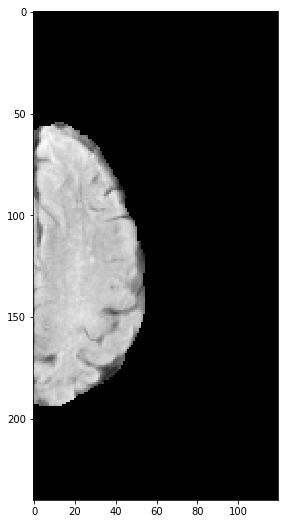

In [332]:
plt.imshow(flair[100], cmap='Greys');

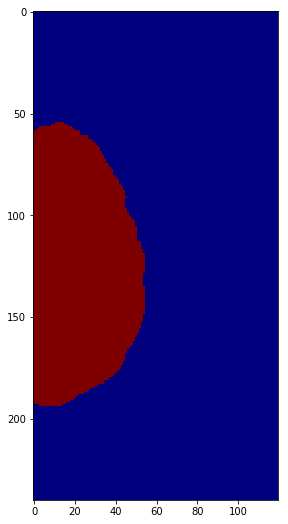

In [333]:
plt.imshow(masks[100]);

In [334]:
modality = 1
all_t1_images = [d[brain]['images'][modality].transpose(2,1,0)[:,:,width/2:] for brain in list(d)[:howmany]]

all_t1_images = [1-((brain == 0)*brain.min()+brain) for brain in all_t1_images]

# normalize between 0 and one
image_min, image_max = np.min(all_t1_images), np.max(all_t1_images)
all_t1_images = [(2*(brain-image_min))/(image_max-image_min)-1 for brain in all_t1_images]

t1 = np.concatenate(all_t1_images, axis=0)
t1.shape

(23560, 240, 120)

In [335]:
#np.min(all_t1_images), np.max(all_t1_images)

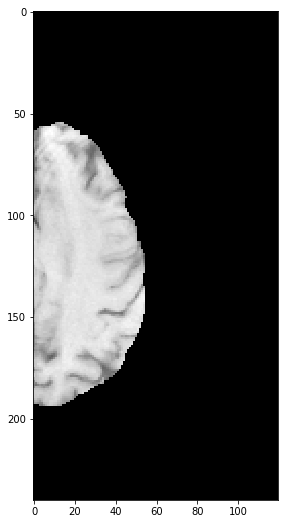

In [336]:
plt.imshow(t1[100], cmap='Greys');

In [337]:
all_labels = [d[brain]['labels'][:].transpose(2,1,0)[:,:,width/2:] for brain in list(d)[:howmany]]
labels = np.concatenate(all_labels, axis=0)
labels.shape

(23560, 240, 120)

In [338]:
np.argmax(labels.sum(axis=(1,2)))

3481

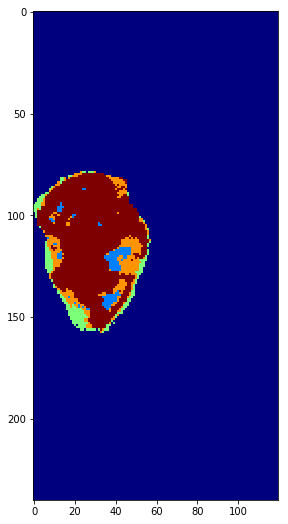

In [339]:
plt.imshow(labels[996])

In [275]:
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets

In [276]:
# plt.rcParams['figure.figsize'] = (10, 9)
# x_widget = ipywidgets.FloatSlider(min=0.0, max=labels.shape[0], step=1);
# interact(lambda(x): plt.imshow(labels[int(x)], cmap='Greys'),x=x_widget);

In [340]:
def get_labels(rightside, mask):
    met = {}
    met["brain"]    = (1.*(mask!= 0).sum()/((mask == 0).sum() + 1e-10))
    met["tumor"]    = (1.*(rightside > 2).sum()/((rightside != 0).sum() + 1e-10))
    
    met["has_enough_brain"] = met["brain"]     > 0.30
    met["has_tumor"]        = met["tumor"]     > 0.05
    return met

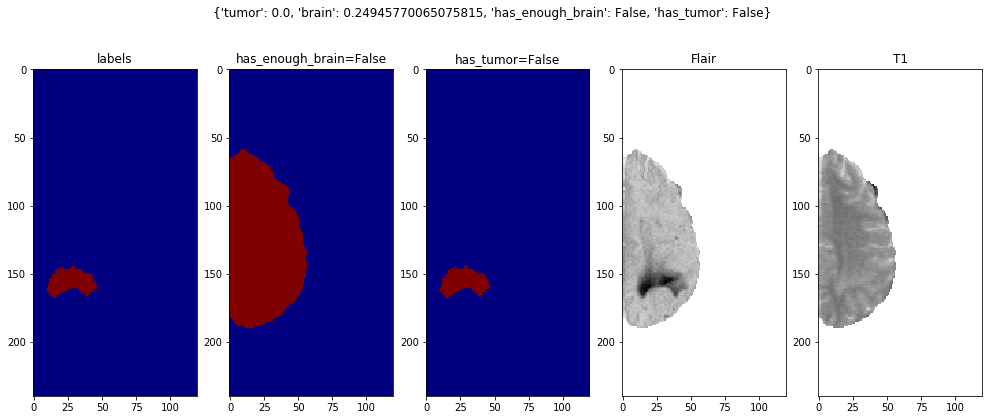

In [341]:
slide = 1195

label = labels[slide]
mask = masks[slide]
fla = flair[slide]
it1 = t1[slide]

met = get_labels(label, mask)

plt.rcParams['figure.figsize'] = (17, 9)
fig, axarr = plt.subplots(1,5);
axarr[0].imshow(label);
axarr[0].set_title("labels")
axarr[1].imshow(mask);
axarr[1].set_title("has_enough_brain="+ str(met["has_enough_brain"]))
axarr[2].imshow(label > 1);
axarr[2].set_title("has_tumor="+ str(met["has_tumor"]))
axarr[3].imshow(1-((fla == 0)*fla.min()+fla), cmap='Greys');
axarr[3].set_title("Flair")
axarr[4].imshow(1-((it1 == 0)*it1.min()+it1), cmap='Greys');
axarr[4].set_title("T1")
# axarr[5].imshow(1.0-it1c, cmap='Greys');
# axarr[5].set_title("T1c")
# axarr[6].imshow(1.0-it2, cmap='Greys');
# axarr[6].set_title("T2")

fig.suptitle(met, y=0.85);

In [14]:
# now create a dataframe and compute the label values

In [345]:
dataset = []
for slide in range(labels.shape[0]):
    met = get_labels(labels[slide], masks[slide])
    met["slide"] = slide
    dataset.append(met)
    #if met["has_enough_brain"]:
    met["flair"] = flair[slide]
    met["t1"] = t1[slide]

In [346]:
stats = pd.DataFrame(dataset)

In [347]:
stats[stats.has_enough_brain].head()

,brain,flair,has_enough_brain,has_tumor,slide,t1,tumor
53,0.302460,"[[0.7429826, 0.7429826, 0.7429826, 0.7429826, ...",True,False,53,"[[0.84137523, 0.84137523, 0.84137523, 0.841375...",0.0
54,0.306359,"[[0.7429826, 0.7429826, 0.7429826, 0.7429826, ...",True,False,54,"[[0.84137523, 0.84137523, 0.84137523, 0.841375...",0.0
55,0.310222,"[[0.7429826, 0.7429826, 0.7429826, 0.7429826, ...",True,False,55,"[[0.84137523, 0.84137523, 0.84137523, 0.841375...",0.0
56,0.312910,"[[0.7429826, 0.7429826, 0.7429826, 0.7429826, ...",True,False,56,"[[0.84137523, 0.84137523, 0.84137523, 0.841375...",0.0
57,0.318681,"[[0.7429826, 0.7429826, 0.7429826, 0.7429826, ...",True,False,57,"[[0.84137523, 0.84137523, 0.84137523, 0.841375...",0.0


In [348]:
#tostudy = np.random.choice(stats["slide"].unique(), 20)

In [349]:
# for sample in tostudy:
#     plt.plot(stats[stats["slide"]==sample].slide, stats[stats["sample"]==sample].necrosis, label=sample);
# plt.legend();

In [20]:
#build dataset
#stratify on two variables

In [350]:
#base = stats[stats.has_enough_brain][["sample", "slide", "has_tumor", "has_necrosis"]]
base = stats[stats.has_enough_brain]
base.shape

(7666, 7)

In [351]:
import collections
print "tumor", collections.Counter(base.has_tumor)

tumor Counter({False: 5019, True: 2647})


In [352]:
#np.savez(open("domaina.npz", "w"), np.asarray(list(domaina.flair.as_matrix())))

In [353]:
#np.savez(open("domainb.npz", "w"), np.asarray(list(domainb.t1.as_matrix())))

In [354]:
base.head()

,brain,flair,has_enough_brain,has_tumor,slide,t1,tumor
53,0.302460,"[[0.7429826, 0.7429826, 0.7429826, 0.7429826, ...",True,False,53,"[[0.84137523, 0.84137523, 0.84137523, 0.841375...",0.0
54,0.306359,"[[0.7429826, 0.7429826, 0.7429826, 0.7429826, ...",True,False,54,"[[0.84137523, 0.84137523, 0.84137523, 0.841375...",0.0
55,0.310222,"[[0.7429826, 0.7429826, 0.7429826, 0.7429826, ...",True,False,55,"[[0.84137523, 0.84137523, 0.84137523, 0.841375...",0.0
56,0.312910,"[[0.7429826, 0.7429826, 0.7429826, 0.7429826, ...",True,False,56,"[[0.84137523, 0.84137523, 0.84137523, 0.841375...",0.0
57,0.318681,"[[0.7429826, 0.7429826, 0.7429826, 0.7429826, ...",True,False,57,"[[0.84137523, 0.84137523, 0.84137523, 0.841375...",0.0


In [355]:
import sklearn, sklearn.model_selection
#tosplit = base.has_tumor
#train, holdout = sklearn.model_selection.train_test_split(base, stratify=tosplit, train_size=0.8)

In [356]:
train = base

In [357]:
print train.shape
# print holdout.shape

(7666, 7)


In [358]:
collections.Counter(train.has_tumor)

Counter({False: 5019, True: 2647})

In [359]:
def sample_ratio(samples, ratio_with_tumor, dataframe):
    num_withtumor = int(samples*ratio_with_tumor)
    num_notumor   = int(samples*(1.0-ratio_with_tumor))
    
    with_tumor    = np.random.choice(dataframe[dataframe.has_tumor == True].index, num_withtumor)
    without_tumor = np.random.choice(dataframe[dataframe.has_tumor == False].index, num_notumor)
    
    return dataframe.loc[np.concatenate([with_tumor, without_tumor],axis=0)]

In [360]:
domaina = sample_ratio(2500, 0.5, train)
domainb = sample_ratio(2500, 1.0, train)

In [361]:
collections.Counter(domaina.has_tumor)

Counter({False: 1250, True: 1250})

In [362]:
collections.Counter(domainb.has_tumor)

Counter({True: 2500})

In [363]:
domainb.head()

,brain,flair,has_enough_brain,has_tumor,slide,t1,tumor
7325,0.325540,"[[0.7645954, 0.7645954, 0.7645954, 0.7645954, ...",True,True,7325,"[[0.70435286, 0.70435286, 0.70435286, 0.704352...",0.566186
14980,0.314108,"[[0.7406403, 0.7406403, 0.7406403, 0.7406403, ...",True,True,14980,"[[0.799013, 0.799013, 0.799013, 0.799013, 0.79...",0.164785
17118,0.459706,"[[0.74972737, 0.74972737, 0.74972737, 0.749727...",True,True,17118,"[[0.7330909, 0.7330909, 0.7330909, 0.7330909, ...",0.438513
18520,0.428217,"[[0.6597966, 0.6597966, 0.6597966, 0.6597966, ...",True,True,18520,"[[0.7830874, 0.7830874, 0.7830874, 0.7830874, ...",0.206476
12460,0.352938,"[[0.8024, 0.8024, 0.8024, 0.8024, 0.8024, 0.80...",True,True,12460,"[[0.78590727, 0.78590727, 0.78590727, 0.785907...",0.534572


In [364]:
import os

In [366]:
path = "cyclegan/datasets/brats2013-var/"
for i in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    print i
    domainb = sample_ratio(2500, i, train)
    print collections.Counter(domainb.has_tumor)
    thispath = path + "brats2013_" + str(i)
    if not os.path.exists(thispath):
        os.makedirs(thispath + "/trainA")
        os.makedirs(thispath + "/testA")
        os.makedirs(thispath + "/trainB")
        os.makedirs(thispath + "/testB")
    print thispath
        
    import skimage
    from skimage.io import imread, imsave

    for i, row in domaina.iterrows():
        img = row.flair
        name = str(row.slide) + "-" + str(row.has_tumor)
        imsave(thispath + "/trainA/" + name + ".png", imgg.astype(np.float32))
        imsave(thispath + "/testA/" + name + ".png", imgg.astype(np.float32))

    for i, row in domainb.iterrows():
        img = row.t1
        name = str(row.slide) + "-" + str(row.has_tumor)
        imsave(thispath + "/trainB/" + name + ".png", imgg.astype(np.float32))
        imsave(thispath + "/testB/" + name + ".png", imgg.astype(np.float32))
    

0.0
Counter({False: 2500})
cyclegan/datasets/brats2013-var/brats2013_0.0
0.1
Counter({False: 2250, True: 250})
cyclegan/datasets/brats2013-var/brats2013_0.1
0.2
Counter({False: 2000, True: 500})
cyclegan/datasets/brats2013-var/brats2013_0.2
0.3
Counter({False: 1750, True: 750})
cyclegan/datasets/brats2013-var/brats2013_0.3
0.4
Counter({False: 1500, True: 1000})
cyclegan/datasets/brats2013-var/brats2013_0.4
0.5
Counter({False: 1250, True: 1250})
cyclegan/datasets/brats2013-var/brats2013_0.5
0.6
Counter({True: 1500, False: 1000})
cyclegan/datasets/brats2013-var/brats2013_0.6
0.7
Counter({True: 1750, False: 750})
cyclegan/datasets/brats2013-var/brats2013_0.7
0.8
Counter({True: 2000, False: 499})
cyclegan/datasets/brats2013-var/brats2013_0.8
0.9
Counter({True: 2250, False: 249})
cyclegan/datasets/brats2013-var/brats2013_0.9
1.0
Counter({True: 2500})
cyclegan/datasets/brats2013-var/brats2013_1.0


In [ ]:
thispath = "cyclegan/datasets/brats2013-var/holdout"
if not os.path.exists(thispath):
        os.makedirs(thispath + "/trainA")
        os.makedirs(thispath + "/trainB")
print thispath

import skimage
from skimage.io import imread, imsave

#pulled from valid set
holdout = sample_ratio(2500, 0.5, train)

for i, row in holdout.iterrows():
    img = row.flair
    name = str(row["sample"]) + "-" + str(row.slide) + "-" + str(row.has_tumor) + "-" + str(row.has_necrosis)
    imsave(thispath + "/trainA/" + name + ".png", imgg.astype(np.float32))
    
for i, row in holdout.iterrows():
    img = row.t1
    name = str(row["sample"]) + "-" + str(row.slide) + "-" + str(row.has_tumor) + "-" + str(row.has_necrosis)
    imsave(thispath + "/trainB/" + name + ".png", imgg.astype(np.float32))

In [342]:
imsave("/Tmp/test.png", flair[100].astype(np.float32))

In [343]:
A_img = imread("/Tmp/test.png")

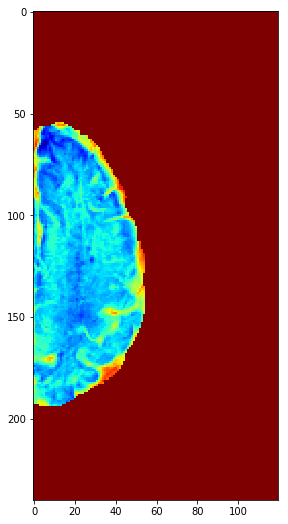

In [344]:
plt.imshow(A_img)

In [322]:
A_img.max()

65535